# 최근접 이웃(K-Nearest Neighbor, KNN)

* 특별한 예측 모델 없이 가장 가까운 데이터 포인트를 기반으로 예측을 수행하는 방법
* 분류와 회귀 모두 지원
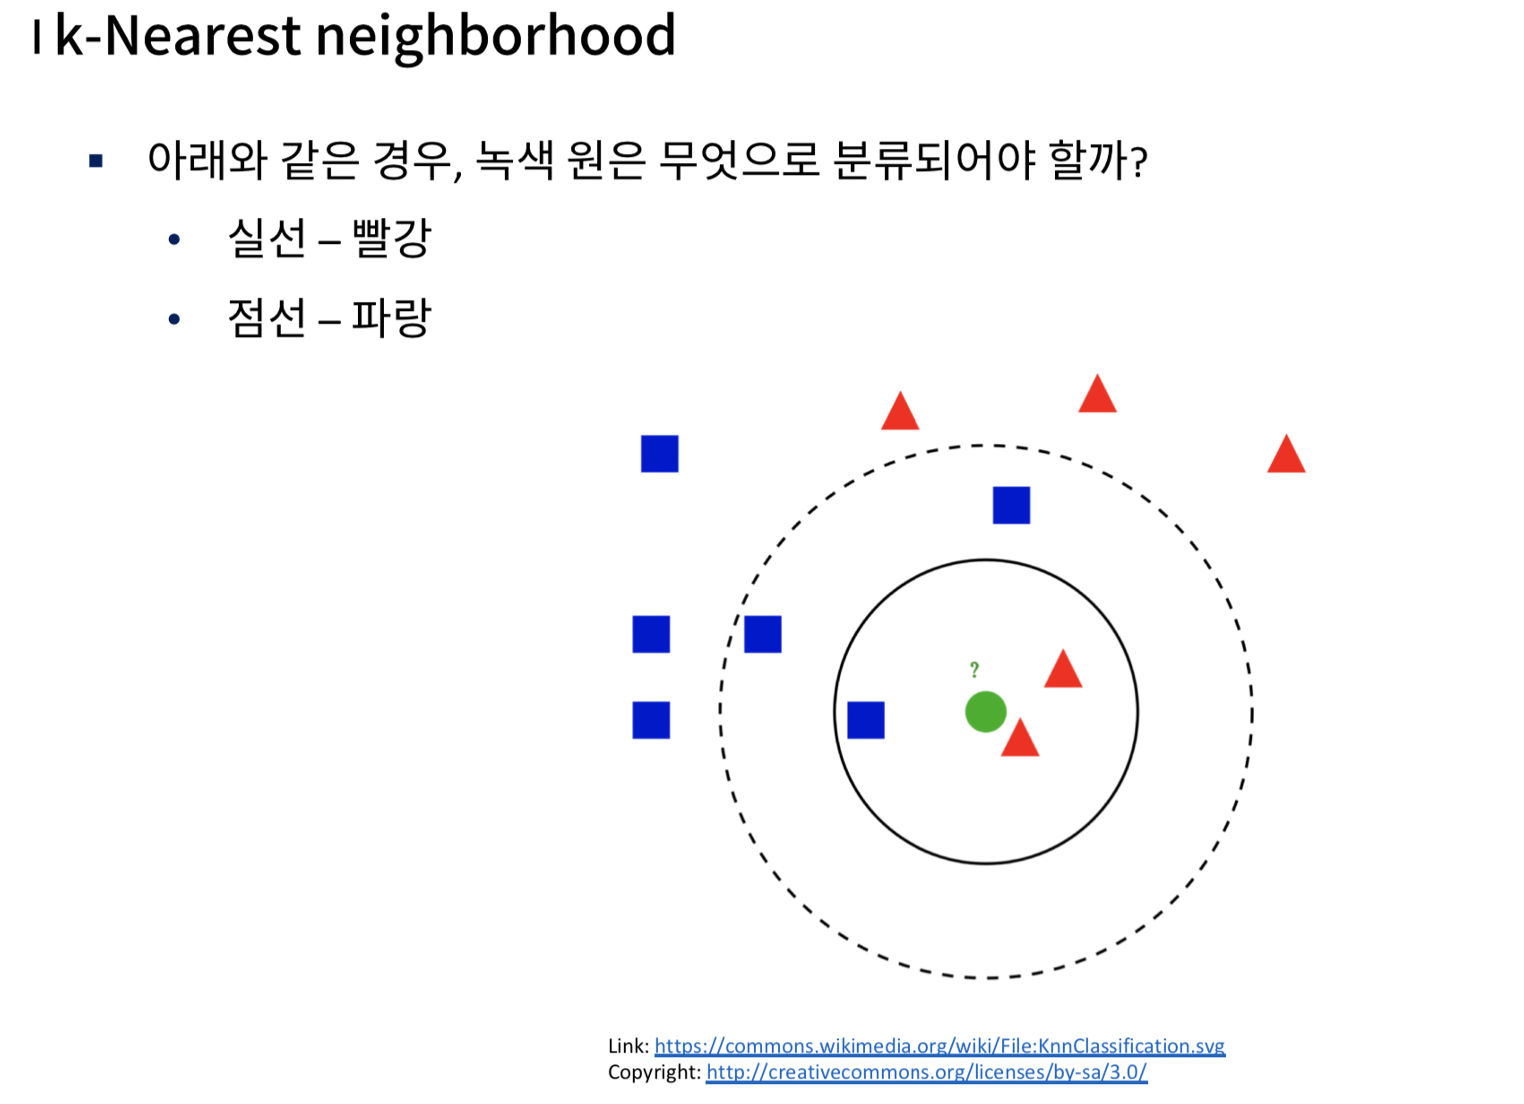

In [148]:
import pandas as pd
import numpy as np
import multiprocessing
import matplotlib.pyplot as plt

plt.style.use(['seaborn-whitegrid'])

/var/folders/9q/y4ybk96d7nb9d0spg4xhbx7m0000gn/T/ipykernel_17942/880865195.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(['seaborn-whitegrid'])


In [149]:
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor # KNN은 분류, 회귀 모두 지원. 모두 사용할 것이기 때문에 둘 다 import
from sklearn.manifold import TSNE
from sklearn.datasets import load_iris, load_breast_cancer
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

## K 최근접 이웃 분류

* 입력 데이터 포인트와 가장 가까운 k개의 훈련 데이터 포인트가 출력
* k개의 데이터 포인트 중 가장 많은 클래스가 예측 결과

### 붓꽃 데이터

In [150]:
iris = load_iris()
iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
iris_df['Target'] = iris.target
iris_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [151]:
X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [152]:
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

In [153]:
model = KNeighborsClassifier()
model.fit(X_train, y_train) # 전처리하지 않은 데이터에 대해서 학습

KNeighborsClassifier()

In [154]:
print("전처리 하지 않은 학습 데이터 점수 : {}" .format(model.score(X_train, y_train)))
print("전처리 하지 않은 평가 데이터 점수 : {}" .format(model.score(X_test, y_test)))

전처리 하지 않은 학습 데이터 점수 : 0.9583333333333334
전처리 하지 않은 평가 데이터 점수 : 0.9666666666666667


In [155]:
model = KNeighborsClassifier()
model.fit(X_train_scale, y_train) # 전처리한 데이터에 대해서 학습

KNeighborsClassifier()

In [156]:
print("전처리한 학습 데이터 점수 : {}" .format(model.score(X_train_scale, y_train)))
print("전처리한 않은 평가 데이터 점수 : {}" .format(model.score(X_test_scale, y_test)))

전처리한 학습 데이터 점수 : 0.95
전처리한 않은 평가 데이터 점수 : 0.9666666666666667


In [157]:
cross_validate(
    estimator= KNeighborsClassifier(),
    X=X, y=y,
    cv=5,
    n_jobs=multiprocessing.cpu_count(),
    verbose=True
)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:    1.2s remaining:    1.8s
[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:    1.2s finished


{'fit_time': array([0.00046301, 0.0004344 , 0.00068569, 0.00046468, 0.00047684]),
 'score_time': array([0.00075221, 0.00074577, 0.00083518, 0.00075126, 0.00075293]),
 'test_score': array([0.96666667, 1.        , 0.93333333, 0.96666667, 1.        ])}

In [158]:
# KNN에서 최적화할 수 있는 방법
param_grid = [
    {
        'n_neighbors' : [3, 5, 7],
        'weights' : ['uniform', 'distance'],
        'algorithm' : ['ball_tree', 'kd_tree', 'brute']
    }
]

In [159]:
gs = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_grid,
    n_jobs=multiprocessing.cpu_count(),
    verbose=True
)

In [160]:
gs.fit(X, y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=8,
             param_grid=[{'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                          'n_neighbors': [3, 5, 7],
                          'weights': ['uniform', 'distance']}],
             verbose=True)

In [161]:
gs.best_estimator_

KNeighborsClassifier(algorithm='ball_tree', n_neighbors=7)

In [162]:
print("GridSearchCV best Score : {}" .format(gs.best_score_))

GridSearchCV best Score : 0.9800000000000001


### 시각화

In [163]:
def make_meshgrid(x, y, h=0.02) :
    x_min, x_max = x.min()-1, x.max()+1
    y_min, y_max = y.min()-1, y.max()+1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy 

def plot_contours(clf, xx, yy, **params) :
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = plt.contourf(xx, yy, Z, **params)
    return out

In [164]:
tsne = TSNE(n_components=2) # 2개 차원으로 축소
X_comp = tsne.fit_transform(X)

In [165]:
iris_comp_df = pd.DataFrame(data=X_comp)
iris_comp_df['Target'] = y
iris_comp_df

,0,1,Target
0,-26.623850,-2.969567,0
1,-29.334204,-2.056246,0
2,-29.084578,-3.268165,0
3,-29.577831,-2.902209,0
4,-26.578043,-3.395158,0
...,...,...,...
145,13.215853,0.308424,2
146,10.208112,1.520699,2
147,12.290833,0.510333,2
148,13.937300,0.956695,2


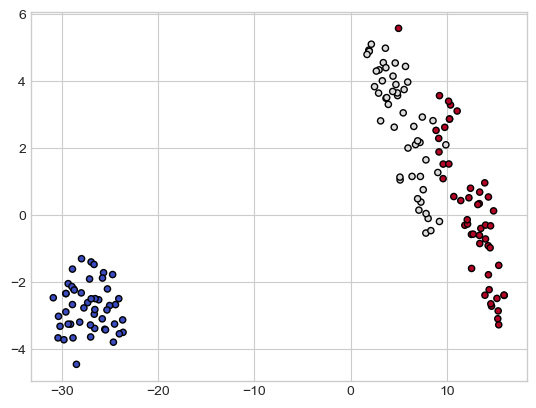

In [166]:
plt.scatter(X_comp[:, 0], X_comp[:, 1],
            c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')

In [167]:
model = KNeighborsClassifier()
model.fit(X_comp, y)

predict = model.predict(X_comp)

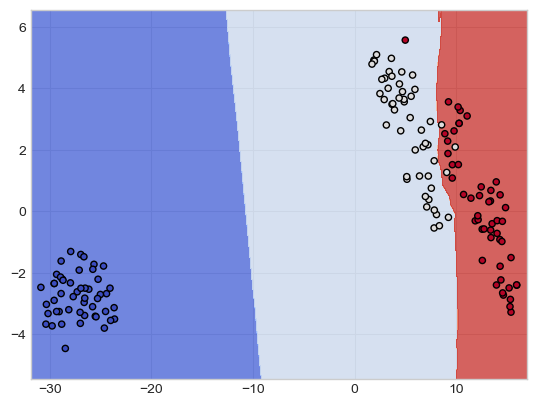

In [168]:
xx, yy = make_meshgrid(X_comp[:, 0], X_comp[:, 1])
plot_contours(model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X_comp[:, 0], X_comp[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')

### 유방암 데이터

In [169]:
cancer = load_breast_cancer()

In [170]:
cancer_df = pd.DataFrame(data=cancer.data, columns=cancer.feature_names)
cancer_df['target'] = cancer.target
cancer_df

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0


In [171]:
X, y = cancer.data, cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [172]:
# 훈련용 데이터와 학습용 데이터가 어떻게 나뉘는지 
cancer_train_df = pd.DataFrame(data=X_train, columns=cancer.feature_names)
cancer_train_df['target'] = y_train
cancer_train_df

# 전체 569개 data에세 455개 data만으로 training. 114개 data로는 testing

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,12.21,18.02,78.31,458.4,0.09231,0.07175,0.043920,0.020270,0.1695,0.05916,...,24.04,93.85,624.6,0.1368,0.2170,0.24130,0.08829,0.3218,0.07470,1
1,10.94,18.59,70.39,370.0,0.10040,0.07460,0.049440,0.029320,0.1486,0.06615,...,25.58,82.76,472.4,0.1363,0.1644,0.14120,0.07887,0.2251,0.07732,1
2,12.54,16.32,81.25,476.3,0.11580,0.10850,0.059280,0.032790,0.1943,0.06612,...,21.40,86.67,552.0,0.1580,0.1751,0.18890,0.08411,0.3155,0.07538,1
3,11.84,18.70,77.93,440.6,0.11090,0.15160,0.121800,0.051820,0.2301,0.07799,...,28.12,119.40,888.7,0.1637,0.5775,0.69560,0.15460,0.4761,0.14020,0
4,11.67,20.02,75.21,416.2,0.10160,0.09453,0.042000,0.021570,0.1859,0.06461,...,28.81,87.00,550.6,0.1550,0.2964,0.27580,0.08120,0.3206,0.08950,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,10.26,16.58,65.85,320.8,0.08877,0.08066,0.043580,0.024380,0.1669,0.06714,...,22.04,71.08,357.4,0.1461,0.2246,0.17830,0.08333,0.2691,0.09479,1
451,18.94,21.31,123.60,1130.0,0.09009,0.10290,0.108000,0.079510,0.1582,0.05461,...,26.58,165.90,1866.0,0.1193,0.2336,0.26870,0.17890,0.2551,0.06589,0
452,10.08,15.11,63.76,317.5,0.09267,0.04695,0.001597,0.002404,0.1703,0.06048,...,21.18,75.39,437.0,0.1521,0.1019,0.00692,0.01042,0.2933,0.07697,1
453,18.31,18.58,118.60,1041.0,0.08588,0.08468,0.081690,0.058140,0.1621,0.05425,...,26.36,139.20,1410.0,0.1234,0.2445,0.35380,0.15710,0.3206,0.06938,0


In [173]:
# 훈련용 데이터와 학습용 데이터가 어떻게 나뉘는지 
cancer_test_df = pd.DataFrame(data=X_test, columns=cancer.feature_names)
cancer_test_df['target'] = y_test
cancer_test_df

# 전체 569개 data에세 455개 data만으로 training. 114개 data로는 testing

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,14.44,15.18,93.97,640.1,0.09970,0.10210,0.08487,0.05532,0.1724,0.06081,...,19.85,108.60,766.9,0.1316,0.2735,0.31030,0.15990,0.2691,0.07683,1
1,13.17,18.22,84.28,537.3,0.07466,0.05994,0.04859,0.02870,0.1454,0.05549,...,23.89,95.10,687.6,0.1282,0.1965,0.18760,0.10450,0.2235,0.06925,1
2,10.49,19.29,67.41,336.1,0.09989,0.08578,0.02995,0.01201,0.2217,0.06481,...,23.31,74.22,402.8,0.1219,0.1486,0.07987,0.03203,0.2826,0.07552,1
3,14.87,16.67,98.64,682.5,0.11620,0.16490,0.16900,0.08923,0.2157,0.06768,...,27.37,127.10,1095.0,0.1878,0.4480,0.47040,0.20270,0.3585,0.10650,0
4,20.18,23.97,143.70,1245.0,0.12860,0.34540,0.37540,0.16040,0.2906,0.08142,...,31.72,170.30,1623.0,0.1639,0.6164,0.76810,0.25080,0.5440,0.09964,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,12.00,15.65,76.95,443.3,0.09723,0.07165,0.04151,0.01863,0.2079,0.05968,...,24.90,87.78,567.9,0.1377,0.2003,0.22670,0.07632,0.3379,0.07924,1
110,16.74,21.59,110.10,869.5,0.09610,0.13360,0.13480,0.06018,0.1896,0.05656,...,29.02,133.50,1229.0,0.1563,0.3835,0.54090,0.18130,0.4863,0.08633,0
111,19.44,18.82,128.10,1167.0,0.10890,0.14480,0.22560,0.11940,0.1823,0.06115,...,30.39,153.90,1740.0,0.1514,0.3725,0.59360,0.20600,0.3266,0.09009,0
112,16.65,21.38,110.00,904.6,0.11210,0.14570,0.15250,0.09170,0.1995,0.06330,...,31.56,177.00,2215.0,0.1805,0.3578,0.46950,0.20950,0.3613,0.09564,0


In [174]:
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

In [175]:
model = KNeighborsClassifier()
model.fit(X_train, y_train) # scale하지 않은 data 학습

KNeighborsClassifier()

In [176]:
print("전처리 하지 않은 학습 데이터 점수 : {}" .format(model.score(X_train, y_train)))
print("전처리 하지 않은 평가 데이터 점수 : {}" .format(model.score(X_test, y_test)))

전처리 하지 않은 학습 데이터 점수 : 0.9428571428571428
전처리 하지 않은 평가 데이터 점수 : 0.9649122807017544


In [177]:
model = KNeighborsClassifier()
model.fit(X_train_scale, y_train)

KNeighborsClassifier()

In [178]:
print("전처리한 학습 데이터 점수 : {}" .format(model.score(X_train_scale, y_train)))
print("전처리한 않은 평가 데이터 점수 : {}" .format(model.score(X_test_scale, y_test)))

전처리한 학습 데이터 점수 : 0.9802197802197802
전처리한 않은 평가 데이터 점수 : 0.956140350877193


In [179]:
estimator = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier()
)

cross_validate(
    estimator=estimator,
    X=X, y=y,
    cv=5,
    n_jobs=multiprocessing.cpu_count(),
    verbose=True
)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:    0.0s finished


{'fit_time': array([0.00184202, 0.00154805, 0.00066304, 0.00146413, 0.00056291]),
 'score_time': array([0.00334191, 0.0030241 , 0.00238705, 0.00276875, 0.00247693]),
 'test_score': array([0.96491228, 0.95614035, 0.98245614, 0.95614035, 0.96460177])}

In [180]:
pipe = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('model', KNeighborsClassifier())
    ]
)

In [181]:
param_grid = [
    {
        'model__n_neighbors' : [3, 5, 7],
        'model__weights' : ['uniform', 'distance'],
        'model__algorithm' : ['ball_tree', 'kd_tree', 'brute']
    }
]

In [182]:
gs = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    n_jobs=multiprocessing.cpu_count(),
    verbose=True
)

In [183]:
gs.fit(X, y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', KNeighborsClassifier())]),
             n_jobs=8,
             param_grid=[{'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
                          'model__n_neighbors': [3, 5, 7],
                          'model__weights': ['uniform', 'distance']}],
             verbose=True)

In [184]:
gs.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 KNeighborsClassifier(algorithm='ball_tree', n_neighbors=7))])

In [185]:
print("GridSearchCV best score : {}" .format(gs.best_score_))

GridSearchCV best score : 0.9701288619779538


### 시각화

In [186]:
tsne = TSNE(n_components=2)
X_comp = tsne.fit_transform(X)

In [187]:
cancer_comp_df = pd.DataFrame(data=X_comp)
cancer_comp_df['target'] = y
cancer_comp_df

,0,1,target
0,42.470364,-12.189198,0
1,42.634861,-9.474772,0
2,38.015316,-9.551566,0
3,-17.497292,1.601614,0
4,36.836418,-7.462237,0
...,...,...,...
564,44.182678,-8.862216,0
565,38.932762,-8.915270,0
566,22.333675,-2.672750,0
567,40.486744,-9.563749,0


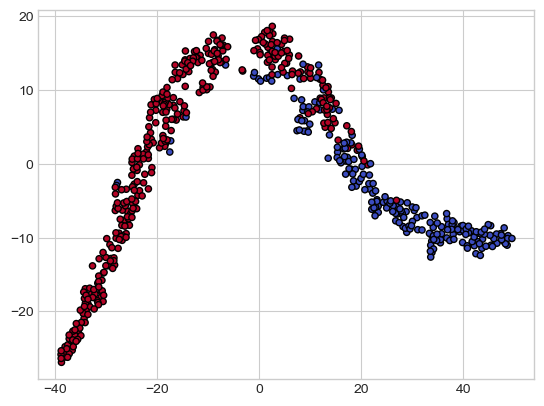

In [188]:
plt.scatter(X_comp[:, 0], X_comp[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k');

In [189]:
model = KNeighborsClassifier()
model.fit(X_comp, y)

predict = model.predict(X_comp)

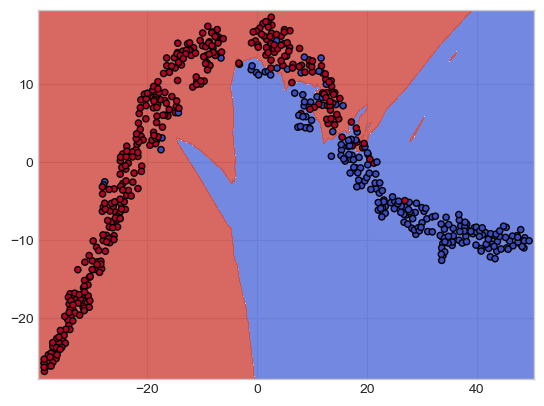

In [190]:
xx, yy = make_meshgrid(X_comp[:, 0], X_comp[:, 1])
plot_contours(model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X_comp[:, 0], X_comp[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')


### 와인 데이터

 기본적으로 거리 기반으로 알고리즘이 수행되기 떄문에 Class구분이 명확한 data에 대해서는 분류가 잘 된다. <br>
 그렇다면 Class 구분이 불명확한 data들은?

In [191]:
from sklearn.datasets import load_wine

wine = load_wine()

In [192]:
wine_df = pd.DataFrame(data=wine.data, columns=wine.feature_names)
wine_df['target'] = wine.target
wine_df

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0,2
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0,2
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0,2
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0,2


In [193]:
X, y = wine.data, wine.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [194]:
# 훈련용 데이터와 학습용 데이터가 어떻게 나뉘는지 
wine_train_df = pd.DataFrame(data=X_train, columns=wine.feature_names)
wine_train_df['target'] = y_train
wine_train_df

# 훈련용 데이터 142개

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,13.49,1.66,2.24,24.0,87.0,1.88,1.84,0.27,1.03,3.74,0.98,2.78,472.0,1
1,12.96,3.45,2.35,18.5,106.0,1.39,0.70,0.40,0.94,5.28,0.68,1.75,675.0,2
2,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0
3,12.64,1.36,2.02,16.8,100.0,2.02,1.41,0.53,0.62,5.75,0.98,1.59,450.0,1
4,13.88,5.04,2.23,20.0,80.0,0.98,0.34,0.40,0.68,4.90,0.58,1.33,415.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,13.68,1.83,2.36,17.2,104.0,2.42,2.69,0.42,1.97,3.84,1.23,2.87,990.0,0
138,12.67,0.98,2.24,18.0,99.0,2.20,1.94,0.30,1.46,2.62,1.23,3.16,450.0,1
139,11.76,2.68,2.92,20.0,103.0,1.75,2.03,0.60,1.05,3.80,1.23,2.50,607.0,1
140,12.16,1.61,2.31,22.8,90.0,1.78,1.69,0.43,1.56,2.45,1.33,2.26,495.0,1


In [214]:
# 훈련용 데이터와 학습용 데이터가 어떻게 나뉘는지 
wine_test_df = pd.DataFrame(data=X_test, columns=wine.feature_names)
wine_test_df['target'] = y_test
wine_test_df

# 학습용 데이터 36개

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,12.29,3.17,2.21,18.0,88.0,2.85,2.99,0.45,2.81,2.30,1.42,2.83,406.0,1
1,13.48,1.81,2.41,20.5,100.0,2.70,2.98,0.26,1.86,5.10,1.04,3.47,920.0,0
2,13.17,5.19,2.32,22.0,93.0,1.74,0.63,0.61,1.55,7.90,0.60,1.48,725.0,2
3,12.25,1.73,2.12,19.0,80.0,1.65,2.03,0.37,1.63,3.40,1.00,3.17,510.0,1
4,14.38,1.87,2.38,12.0,102.0,3.30,3.64,0.29,2.96,7.50,1.20,3.00,1547.0,0
5,14.75,1.73,2.39,11.4,91.0,3.10,3.69,0.43,2.81,5.40,1.25,2.73,1150.0,0
6,13.69,3.26,2.54,20.0,107.0,1.83,0.56,0.50,0.80,5.88,0.96,1.82,680.0,2
7,12.42,2.55,2.27,22.0,90.0,1.68,1.84,0.66,1.42,2.70,0.86,3.30,315.0,1
8,13.50,3.12,2.62,24.0,123.0,1.40,1.57,0.22,1.25,8.60,0.59,1.30,500.0,2
9,12.08,1.83,2.32,18.5,81.0,1.60,1.50,0.52,1.64,2.40,1.08,2.27,480.0,1


In [215]:
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

In [216]:
model = KNeighborsClassifier()
model.fit(X_train, y_train) # scale하지 않은 data 학습

KNeighborsClassifier()

In [217]:
print("전처리 하지 않은 학습 데이터 점수 : {}" .format(model.score(X_train, y_train)))
print("전처리 하지 않은 평가 데이터 점수 : {}" .format(model.score(X_test, y_test)))

전처리 하지 않은 학습 데이터 점수 : 0.7816901408450704
전처리 하지 않은 평가 데이터 점수 : 0.7222222222222222


In [218]:
model = KNeighborsClassifier()
model.fit(X_train_scale, y_train)

KNeighborsClassifier()

In [219]:
print("전처리한 학습 데이터 점수 : {}" .format(model.score(X_train_scale, y_train)))
print("전처리한 평가 데이터 점수 : {}" .format(model.score(X_test_scale, y_test)))

전처리한 학습 데이터 점수 : 0.971830985915493
전처리한 평가 데이터 점수 : 1.0


In [201]:
estimator = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier()
)

cross_validate(
    estimator=estimator,
    X=X, y=y,
    cv=5,
    n_jobs=multiprocessing.cpu_count(),
    verbose=True
)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:    0.0s finished


{'fit_time': array([0.00206685, 0.00261402, 0.00051904, 0.00481296, 0.00146484]),
 'score_time': array([0.00148511, 0.0026722 , 0.0008018 , 0.00312901, 0.00086808]),
 'test_score': array([0.94444444, 0.94444444, 0.97222222, 1.        , 0.88571429])}

In [220]:
pipe = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('model', KNeighborsClassifier())
    ]
)

In [221]:
param_grid = [
    {
        'model__n_neighbors' : [3, 5, 7],
        'model__weights' : ['uniform', 'distance'],
        'model__algorithm' : ['ball_tree', 'kd_tree', 'brute']
    }
]

In [222]:
gs = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    n_jobs=multiprocessing.cpu_count(),
    verbose=True
)

In [223]:
gs.fit(X, y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', KNeighborsClassifier())]),
             n_jobs=8,
             param_grid=[{'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
                          'model__n_neighbors': [3, 5, 7],
                          'model__weights': ['uniform', 'distance']}],
             verbose=True)

In [224]:
gs.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 KNeighborsClassifier(algorithm='ball_tree', n_neighbors=7))])

In [225]:
print("GridSearchCV best score : {}" .format(gs.best_score_))

GridSearchCV best score : 0.9665079365079364


### 시각화

In [226]:
tsne = TSNE(n_components=2)
X_comp = tsne.fit_transform(X)

In [227]:
cancer_comp_df = pd.DataFrame(data=X_comp)
cancer_comp_df['target'] = y
cancer_comp_df

,0,1,target
0,11.326386,-0.667789,0
1,10.996623,0.065190,0
2,13.542080,-0.301189,0
3,16.394600,-0.179806,0
4,2.662922,0.261400,0
...,...,...,...
173,2.623563,-0.170500,2
174,3.054006,-0.144413,2
175,5.667188,-0.080280,2
176,5.837288,0.038036,2


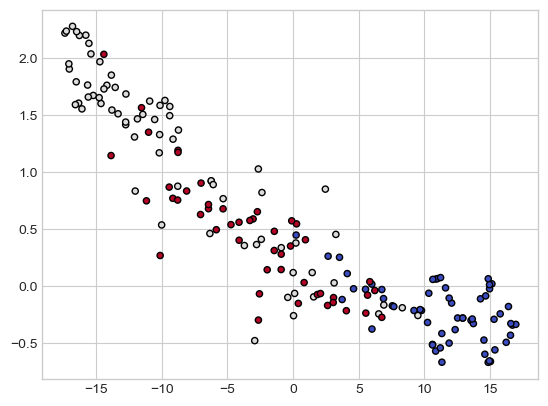

In [228]:
plt.scatter(X_comp[:, 0], X_comp[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k');

In [211]:
model = KNeighborsClassifier()
model.fit(X_comp, y)

predict = model.predict(X_comp)

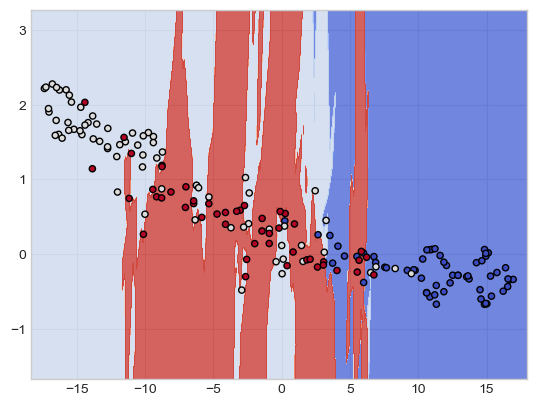

In [212]:
xx, yy = make_meshgrid(X_comp[:, 0], X_comp[:, 1])
plot_contours(model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X_comp[:, 0], X_comp[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')

## K 최근접 이웃 회귀

* K 최근접 이웃 분류와 마찬가지로 예측에 이웃 데이터 포인트 사용
* 이웃 데이터 포인트의 평균이 예측 결과

### 보스턴 주택 가격 데이터 회귀

In [229]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np

boston_df = pd.read_csv(
    filepath_or_buffer="http://lib.stat.cmu.edu/datasets/boston",
    delim_whitespace=True,
    skiprows=21,
    header=None,
)

columns = ['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','MEDV']

#Flatten all the values into a single long list and remove the nulls
values_w_nulls = boston_df.values.flatten()
all_values = values_w_nulls[~np.isnan(values_w_nulls)]

#Reshape the values to have 14 columns and make a new boston_df out of them
boston_df = pd.DataFrame(
    data = all_values.reshape(-1, len(columns)),
    columns = columns,
)

boston_df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


In [270]:
X, y = boston_df.iloc[:, :-1], boston_df.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 

In [271]:
boston_train_df = pd.DataFrame(data=X_train, columns=columns)
boston_train_df['TARGET'] = y_train
boston_train_df

# 훈련 data 404개

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV,TARGET
372,8.26725,0.0,18.10,1.0,0.668,5.875,89.6,1.1296,24.0,666.0,20.2,347.88,8.88,NaN,50.0
70,0.08826,0.0,10.81,0.0,0.413,6.417,6.6,5.2873,4.0,305.0,19.2,383.73,6.72,NaN,24.2
292,0.03615,80.0,4.95,0.0,0.411,6.630,23.4,5.1167,4.0,245.0,19.2,396.90,4.70,NaN,27.9
32,1.38799,0.0,8.14,0.0,0.538,5.950,82.0,3.9900,4.0,307.0,21.0,232.60,27.71,NaN,13.2
353,0.01709,90.0,2.02,0.0,0.410,6.728,36.1,12.1265,5.0,187.0,17.0,384.46,4.50,NaN,30.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349,0.02899,40.0,1.25,0.0,0.429,6.939,34.5,8.7921,1.0,335.0,19.7,389.85,5.89,NaN,26.6
298,0.06466,70.0,2.24,0.0,0.400,6.345,20.1,7.8278,5.0,358.0,14.8,368.24,4.97,NaN,22.5
54,0.01360,75.0,4.00,0.0,0.410,5.888,47.6,7.3197,3.0,469.0,21.1,396.90,14.80,NaN,18.9
209,0.43571,0.0,10.59,1.0,0.489,5.344,100.0,3.8750,4.0,277.0,18.6,396.90,23.09,NaN,20.0


In [272]:
boston_test_df = pd.DataFrame(data=X_test, columns=columns)
boston_test_df['TARGET'] = y_test
boston_test_df

# 평가 data 102개

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV,TARGET
72,0.09164,0.0,10.81,0.0,0.413,6.065,7.8,5.2873,4.0,305.0,19.2,390.91,5.52,NaN,22.8
71,0.15876,0.0,10.81,0.0,0.413,5.961,17.5,5.2873,4.0,305.0,19.2,376.94,9.88,NaN,21.7
471,4.03841,0.0,18.10,0.0,0.532,6.229,90.7,3.0993,24.0,666.0,20.2,395.33,12.87,NaN,19.6
352,0.07244,60.0,1.69,0.0,0.411,5.884,18.5,10.7103,4.0,411.0,18.3,392.33,7.79,NaN,18.6
330,0.04544,0.0,3.24,0.0,0.460,6.144,32.2,5.8736,4.0,430.0,16.9,368.57,9.09,NaN,19.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436,14.42080,0.0,18.10,0.0,0.740,6.461,93.3,2.0026,24.0,666.0,20.2,27.49,18.05,NaN,9.6
438,13.67810,0.0,18.10,0.0,0.740,5.935,87.9,1.8206,24.0,666.0,20.2,68.95,34.02,NaN,8.4
407,11.95110,0.0,18.10,0.0,0.659,5.608,100.0,1.2852,24.0,666.0,20.2,332.09,12.13,NaN,27.9
241,0.10612,30.0,4.93,0.0,0.428,6.095,65.1,6.3361,6.0,300.0,16.6,394.62,12.40,NaN,20.1


In [273]:
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

In [274]:
model = KNeighborsRegressor()
model.fit(X_train, y_train)

KNeighborsRegressor()

In [275]:
print("전처리 하지 않은 학습 데이터 점수 : {}" .format(model.score(X_train, y_train)))
print("전처리 하지 않은 평가 데이터 점수 : {}" .format(model.score(X_test, y_test)))

전처리 하지 않은 학습 데이터 점수 : 0.6821308081039026
전처리 하지 않은 평가 데이터 점수 : 0.6640975525381384


In [276]:
model = KNeighborsRegressor()
model.fit(X_train_scale, y_train)

KNeighborsRegressor()

In [256]:
print("전처리한 학습 데이터 점수 : {}" .format(model.score(X_train_scale, y_train)))
print("전처리한 평가 데이터 점수 : {}" .format(model.score(X_test_scale, y_test)))

# 전처리 한 후에 성능 증가 확인.

전처리한 학습 데이터 점수 : 0.8293917549814228
전처리한 평가 데이터 점수 : 0.7833744814098869


In [286]:
estimator = make_pipeline(
    StandardScaler(),
    KNeighborsRegressor()
)

cross_validate(
    estimator=estimator,
    X=X, y=y,
    cv=5,
    n_jobs=multiprocessing.cpu_count(),
    verbose=True
)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:    1.3s remaining:    1.9s
[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:    1.3s finished


{'fit_time': array([0.00476909, 0.00239491, 0.00446105, 0.00175691, 0.00194025]),
 'score_time': array([0.00201392, 0.00187302, 0.00120401, 0.00108695, 0.00218511]),
 'test_score': array([0.56089547, 0.61917359, 0.48661916, 0.46986886, 0.23133037])}

In [287]:
pipe = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('model', KNeighborsRegressor())
    ]
)

In [288]:
param_grid = [
    {
        'model__n_neighbors' : [3, 5, 7],
        'model__weights' : ['uniform', 'distance'],
        'model__algorithm' : ['ball_tree', 'kd_tree', 'brute']
    }
]

In [289]:
gs = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    n_jobs=multiprocessing.cpu_count(),
    verbose=True
)

In [290]:
gs.fit(X, y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', KNeighborsRegressor())]),
             n_jobs=8,
             param_grid=[{'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
                          'model__n_neighbors': [3, 5, 7],
                          'model__weights': ['uniform', 'distance']}],
             verbose=True)

In [291]:
gs.best_estimator_  # Classifier()에서 weights='uniform'이었는데, Regressor()에서 weight='distance'가 나옴.

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 KNeighborsRegressor(algorithm='ball_tree', n_neighbors=7,
                                     weights='distance'))])

In [292]:
print("GridSearchCV best score : {}" .format(gs.best_score_))

GridSearchCV best score : 0.4973060611762845


### 시각화

In [293]:
tsne = TSNE(n_components=1)
X_comp = tsne.fit_transform(X)

In [294]:
boston_comp_df = pd.DataFrame(data=X_comp)
boston_comp_df['target'] = y
boston_comp_df

,0,target
0,-20.181044,24.0
1,-41.135460,21.6
2,-41.892006,34.7
3,-43.297321,33.4
4,-43.447178,36.2
...,...,...
501,-27.591579,22.4
502,-28.240456,20.6
503,-29.028101,23.9
504,-28.981216,22.0


/var/folders/9q/y4ybk96d7nb9d0spg4xhbx7m0000gn/T/ipykernel_17942/1638329518.py:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_comp, y, c='b', cmap=plt.cm.coolwarm, s=20, edgecolors='k');


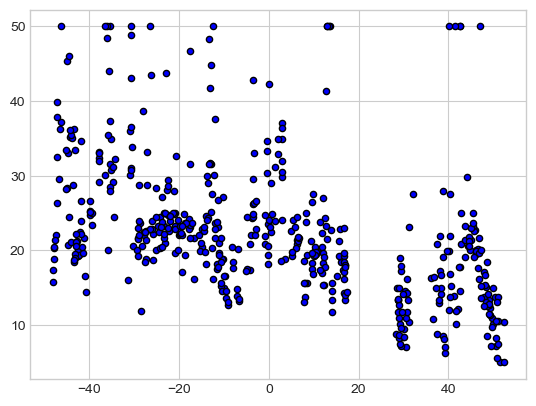

In [295]:
plt.scatter(X_comp, y, c='b', cmap=plt.cm.coolwarm, s=20, edgecolors='k');

In [297]:
model = KNeighborsRegressor()
model.fit(X_comp, y)

predict = model.predict(X_comp)

/var/folders/9q/y4ybk96d7nb9d0spg4xhbx7m0000gn/T/ipykernel_17942/2040553899.py:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_comp, y, c='b', cmap=plt.cm.coolwarm, s=20, edgecolors='k');
/var/folders/9q/y4ybk96d7nb9d0spg4xhbx7m0000gn/T/ipykernel_17942/2040553899.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_comp, predict, c='r', cmap=plt.cm.coolwarm, s=20, edgecolors='k')


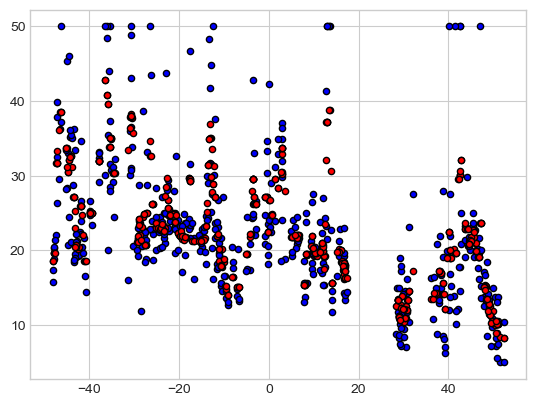

In [298]:
plt.scatter(X_comp, y, c='b', cmap=plt.cm.coolwarm, s=20, edgecolors='k');
plt.scatter(X_comp, predict, c='r', cmap=plt.cm.coolwarm, s=20, edgecolors='k')

# 'b' -> real data
# 'r' -> real data에 대한 predict

### 캘리포니아 주택 가격 데이터 회귀

In [305]:
california = fetch_california_housing()

In [306]:
X, y = california.data, california.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 

In [308]:
california_train_df = pd.DataFrame(data=X_train, columns=california.feature_names)
california_train_df['TARGET'] = y_train 
california_train_df

# 훈련 data 16,512개

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,TARGET
0,2.5067,18.0,4.080793,1.196646,1391.0,2.120427,36.96,-122.03,2.32600
1,2.6125,26.0,5.213152,1.124717,1259.0,2.854875,34.53,-117.31,0.79900
2,6.6756,52.0,7.403800,1.111639,1114.0,2.646081,37.44,-122.14,5.00001
3,2.7159,25.0,5.694853,0.988971,819.0,3.011029,36.37,-119.83,1.01400
4,2.5363,16.0,5.279412,1.064706,1642.0,4.829412,37.07,-120.85,0.86300
...,...,...,...,...,...,...,...,...,...
16507,1.0278,15.0,3.693252,1.000000,543.0,1.665644,32.76,-117.02,1.54200
16508,3.3427,16.0,3.748996,1.146586,951.0,1.909639,33.79,-118.29,1.54200
16509,5.5677,16.0,6.271967,0.970711,918.0,3.841004,34.03,-117.60,1.75400
16510,3.6563,13.0,5.563246,1.107399,1110.0,2.649165,39.17,-120.93,1.64900


In [309]:
california_test_df = pd.DataFrame(data=X_test, columns=california.feature_names)
california_test_df['TARGET'] = y_test 
california_test_df

# 훈련 data 4,128개

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,TARGET
0,3.2656,29.0,5.621622,1.092664,2188.0,4.223938,34.11,-117.34,0.90600
1,2.7396,7.0,6.548077,1.201923,485.0,4.663462,34.59,-117.92,1.25600
2,1.5809,34.0,3.518072,1.060241,625.0,3.765060,33.68,-116.21,1.00000
3,3.1324,28.0,4.228261,1.257246,770.0,1.394928,32.85,-117.30,5.00001
4,4.6944,52.0,5.990196,1.058824,735.0,2.401961,37.97,-122.56,3.98900
...,...,...,...,...,...,...,...,...,...
4123,4.7917,34.0,6.112329,0.986301,1035.0,2.835616,37.25,-121.92,2.43200
4124,4.0061,30.0,5.324153,1.008475,1611.0,3.413136,33.85,-117.97,1.82900
4125,2.7361,14.0,4.206612,0.983471,1224.0,3.371901,32.57,-117.07,0.93600
4126,4.9236,43.0,5.220844,0.962779,1137.0,2.821340,37.26,-121.94,2.38000


In [310]:
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

In [311]:
model = KNeighborsRegressor()
model.fit(X_train, y_train)

KNeighborsRegressor()

In [312]:
print("전처리 하지 않은 학습 데이터 점수 : {}" .format(model.score(X_train, y_train)))
print("전처리 하지 않은 평가 데이터 점수 : {}" .format(model.score(X_test, y_test)))

전처리 하지 않은 학습 데이터 점수 : 0.4506781984703391
전처리 하지 않은 평가 데이터 점수 : 0.1550588466598688


In [313]:
model = KNeighborsRegressor()
model.fit(X_train_scale, y_train)

KNeighborsRegressor()

In [314]:
print("전처리한 학습 데이터 점수 : {}" .format(model.score(X_train_scale, y_train)))
print("전처리한 평가 데이터 점수 : {}" .format(model.score(X_test_scale, y_test)))

# 전처리 한 후에 성능 증가 확인.

전처리한 학습 데이터 점수 : 0.7925200675508837
전처리한 평가 데이터 점수 : 0.6889163672057499


In [315]:
estimator = make_pipeline(
    StandardScaler(),
    KNeighborsRegressor()
)

cross_validate(
    estimator=estimator,
    X=X, y=y,
    cv=5,
    n_jobs=multiprocessing.cpu_count(),
    verbose=True
)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:    1.1s remaining:    1.7s
[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:    1.2s finished


{'fit_time': array([0.00979614, 0.00601602, 0.00600338, 0.0094049 , 0.00590825]),
 'score_time': array([0.18066001, 0.111763  , 0.15406895, 0.20646095, 0.20226097]),
 'test_score': array([0.47879396, 0.4760079 , 0.57624554, 0.50259828, 0.57228584])}

In [316]:
pipe = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('model', KNeighborsRegressor())
    ]
)

In [317]:
param_grid = [
    {
        'model__n_neighbors' : [3, 5, 7],
        'model__weights' : ['uniform', 'distance'],
        'model__algorithm' : ['ball_tree', 'kd_tree', 'brute']
    }
]

In [318]:
gs = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    n_jobs=multiprocessing.cpu_count(),
    verbose=True
)

In [321]:
gs.fit(X, y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', KNeighborsRegressor())]),
             n_jobs=8,
             param_grid=[{'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
                          'model__n_neighbors': [3, 5, 7],
                          'model__weights': ['uniform', 'distance']}],
             verbose=True)

In [322]:
gs.best_estimator_  # Classifier()에서 weights='uniform'이었는데, Regressor()에서 weight='distance'가 나옴.

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 KNeighborsRegressor(algorithm='ball_tree', n_neighbors=7,
                                     weights='distance'))])

In [323]:
print("GridSearchCV best score : {}" .format(gs.best_score_))

GridSearchCV best score : 0.5376515274379832


### 시각화

In [324]:
tsne = TSNE(n_components=1)
X_comp = tsne.fit_transform(X)

In [325]:
boston_comp_df = pd.DataFrame(data=X_comp)
boston_comp_df['target'] = y
boston_comp_df

,0,target
0,-116.764549,4.526
1,89.216087,3.585
2,-98.706490,3.521
3,-90.604317,3.413
4,-89.914688,3.422
...,...,...
20635,-46.845493,0.781
20636,-113.757698,0.771
20637,-23.142410,0.923
20638,-61.931084,0.847


/var/folders/9q/y4ybk96d7nb9d0spg4xhbx7m0000gn/T/ipykernel_17942/1638329518.py:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_comp, y, c='b', cmap=plt.cm.coolwarm, s=20, edgecolors='k');


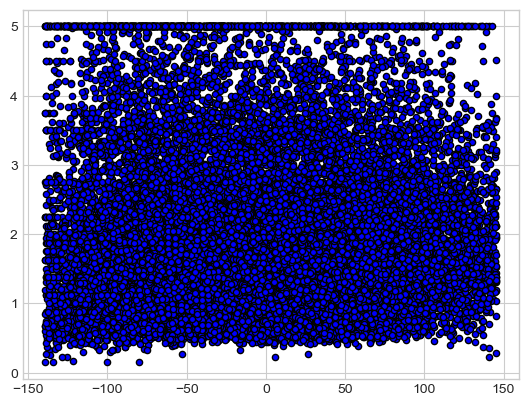

In [326]:
plt.scatter(X_comp, y, c='b', cmap=plt.cm.coolwarm, s=20, edgecolors='k');

In [327]:
model = KNeighborsRegressor()
model.fit(X_comp, y)

predict = model.predict(X_comp)

/var/folders/9q/y4ybk96d7nb9d0spg4xhbx7m0000gn/T/ipykernel_17942/630948040.py:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_comp, y, c='b', cmap=plt.cm.coolwarm, s=20, edgecolors='k');
/var/folders/9q/y4ybk96d7nb9d0spg4xhbx7m0000gn/T/ipykernel_17942/630948040.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_comp, predict, c='r', cmap=plt.cm.coolwarm, s=20, edgecolors='k')


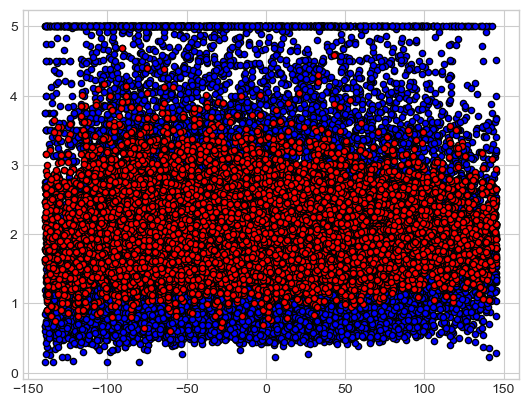

In [328]:
plt.scatter(X_comp, y, c='b', cmap=plt.cm.coolwarm, s=20, edgecolors='k');
plt.scatter(X_comp, predict, c='r', cmap=plt.cm.coolwarm, s=20, edgecolors='k')

# 'b' -> real data
# 'r' -> real data에 대한 predict